Assign4: Linear Regression
Due Date: Oct 14, before midnight (11:59:59PM)

We will continue with the Online News Popularity dataset as in previous assignments. This dataset has 61 attributes and 39644 points. Ignore the following attributes for this assignment: 0-1, 4-6, 13-38. We will use all the remaining attributes, but with the last attribute (60; shares) as the target variable. Thus you will have 29 independent attributes and 1 dependent or target attribute. Your goal is to build a regression model to predict the number of shares of a news article.

Data Preprocessing
Set np.random.seed(42) and then shuffle the points using np.random.shuffle. Next, split the data into three parts after shuffling the points, by taking the first 31715 points as training data, the next 3964 points as validation data, and the last 3965 points as the test data (that is, 80-10-10 split).

Since the attributes have different scales, you should next standardize the training data so that each independent attribute has mean zero and variance one. You can use the sklearn StandardScaler to do this, or do it by using the formula (xi−μX)/σX(x 
i
​
 −μ 
X
​
 )/σ 
X
​
 , where μXμ 
X
​
  and σXσ 
X
​
  are the mean and standard deviation for an attribute XX, and xix 
i
​
  is one of the values of XX. There is no need to standardize the target variable. Make a note of the training data mean and standard deviation for each attribute.

Then, standardize both the validation and test data independent attributes using the training mean and training std for each attribute.

Finally, augment the training, validation and testing datasets by adding a columns of ones as the first dimension. Make sure to keep the target variable as separate from the independent variables for all three splits.

Part I: Linear Regression via QR Factorization
Implement the linear regression algorithm via QR factorization, namely Algorithm 23.1 on page 602 in Chapter 23.

You must implement QR factorization on your own, as described in Section 23.3.1 (you cannot use numpy.linalg.qr or similar function).

Next, using the QQ and the RR matrices, you must solve for the augmented weight vector ww. CSCI4390 can use numpy.linalg.inv for your solution, but CSCI6390 must implement backsolve via backsubstitution on their own without using the inv function. See Example 23.4 on how backsolve works.

After you have computed the weight vector ww, print it, and then compute the SSE value for the predictions and also the R2R 
2
  statistic on the test data, where:
R2=TSS−SSETSS
R 
2
 = 
TSS
TSS−SSE
​
 
where TSS is the total scatter of the response variable TSS=∑ni=1(yi−μY)2TSS=∑ 
i=1
n
​
 (y 
i
​
 −μ 
Y
​
 ) 
2
 
Part II: Linear Regression with Regularization
Implement ridge regression algorithm (Algo 23.3 on page 610), but using batch gradient descent to solve for ww, via equation (23.35). That is, instead of doing lines 5-7, just use eq (23.35) to compute the gradient, and then update the weight vector as shown in the next equation after (23.35). Repeat until convergence.

Use η=1e−6η=1e−6, but choose the appropriate regularization constant αα, based on the validation set, as follows: For each value of αα, first learn ww on the training set, and then compute the SSE value on the validation set. The value that gives the least validation SSE is the one to choose.

For the αα value try powers of 10 (e.g., 0, 1, 10, 100, 1000, 10000, etc), and then narrow down the range.

Once the best αα and corresponding ww have been found, print those, and then evaluate the model on the testing data. In particular, you should compute the SSE value for the predictions on the test data. You should also report the R2R 
2
  statistic on the test data.

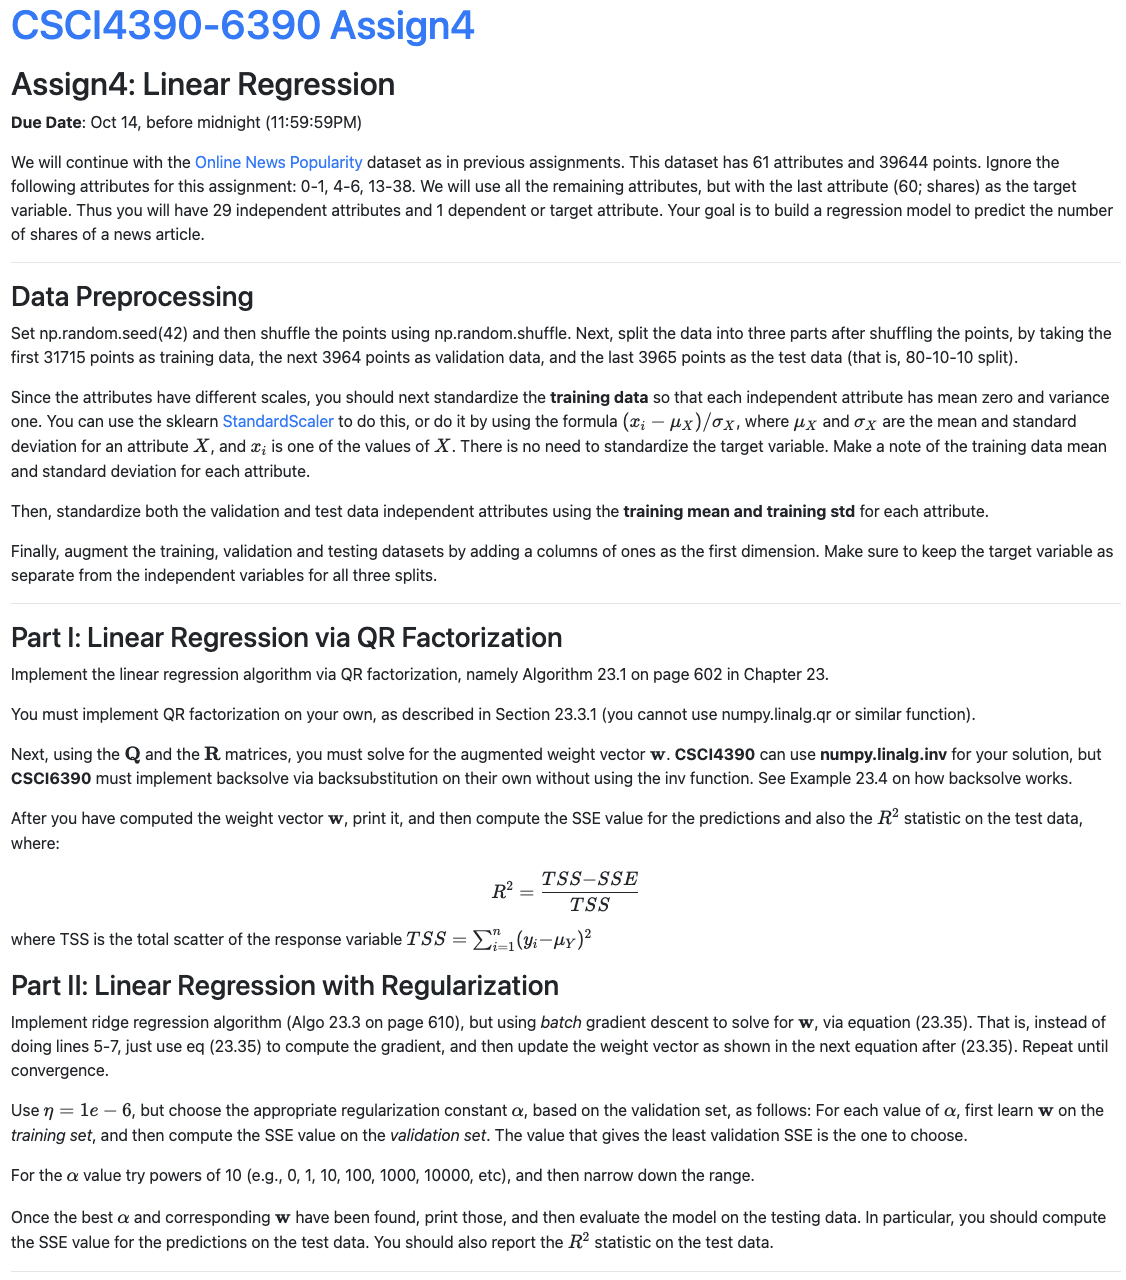

In [20]:
import numpy as np
import numpy.linalg as la
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

## Data Preprocessing 

In [21]:
df = pd.read_csv('OnlineNewsPopularity.csv')
print(df.columns)

Index(['url', ' timedelta', ' n_tokens_title', ' n_tokens_content',
       ' n_unique_tokens', ' n_non_stop_words', ' n_non_stop_unique_tokens',
       ' num_hrefs', ' num_self_hrefs', ' num_imgs', ' num_videos',
       ' average_token_length', ' num_keywords', ' data_channel_is_lifestyle',
       ' data_channel_is_entertainment', ' data_channel_is_bus',
       ' data_channel_is_socmed', ' data_channel_is_tech',
       ' data_channel_is_world', ' kw_min_min', ' kw_max_min', ' kw_avg_min',
       ' kw_min_max', ' kw_max_max', ' kw_avg_max', ' kw_min_avg',
       ' kw_max_avg', ' kw_avg_avg', ' self_reference_min_shares',
       ' self_reference_max_shares', ' self_reference_avg_sharess',
       ' weekday_is_monday', ' weekday_is_tuesday', ' weekday_is_wednesday',
       ' weekday_is_thursday', ' weekday_is_friday', ' weekday_is_saturday',
       ' weekday_is_sunday', ' is_weekend', ' LDA_00', ' LDA_01', ' LDA_02',
       ' LDA_03', ' LDA_04', ' global_subjectivity',
       ' global_sent

In [22]:
c1 = df[df.columns[2:4]]
c2 = df[df.columns[7:13]]
c3 = df[df.columns[39:]]
df = pd.concat([c1, c2, c3], axis=1)
D = df.to_numpy()
D

array([[1.20000000e+01, 2.19000000e+02, 4.00000000e+00, ...,
        0.00000000e+00, 1.87500000e-01, 5.93000000e+02],
       [9.00000000e+00, 2.55000000e+02, 3.00000000e+00, ...,
        5.00000000e-01, 0.00000000e+00, 7.11000000e+02],
       [9.00000000e+00, 2.11000000e+02, 3.00000000e+00, ...,
        5.00000000e-01, 0.00000000e+00, 1.50000000e+03],
       ...,
       [1.00000000e+01, 4.42000000e+02, 2.40000000e+01, ...,
        4.54545455e-02, 1.36363636e-01, 1.90000000e+03],
       [6.00000000e+00, 6.82000000e+02, 1.00000000e+01, ...,
        5.00000000e-01, 0.00000000e+00, 1.10000000e+03],
       [1.00000000e+01, 1.57000000e+02, 1.00000000e+00, ...,
        1.66666667e-01, 2.50000000e-01, 1.30000000e+03]])

In [23]:
np.random.seed(42)
np.random.shuffle(D)
Y = D[:,-1]
D = np.delete(D, -1, axis=1)


In [24]:

train = D[0:31715]
train_Y = Y[0:31715]
print('train : ', train.shape, 'train_Y : ', train_Y.shape)
valid = D[31715:35679]
valid_Y = Y[31715:35679]
print('valid : ', valid.shape, 'valid_Y : ', valid_Y.shape)
test = D[35679:]
test_Y = Y[35679:]
print('test : ', test.shape, 'test_Y : ', test_Y.shape)
Y

train :  (31715, 29) train_Y :  (31715,)
valid :  (3964, 29) valid_Y :  (3964,)
test :  (3965, 29) test_Y :  (3965,)


array([ 2900.,  1300., 17700., ...,  1100.,  1500.,   829.])

In [25]:
scaler = StandardScaler()
scaler.fit(train)
train=scaler.transform(train)
scaler.fit(test)
test=scaler.transform(test)
scaler.fit(valid)
valid=scaler.transform(valid)

In [26]:

one = np.ones(train.shape[0])
train = np.insert(train, 0, one, axis=1)
one = np.ones(valid.shape[0])
valid = np.insert(valid, 0, one, axis=1)
one = np.ones(test.shape[0])
test = np.insert(test, 0, one, axis=1)

## QR factorization

In [27]:
np.random.seed(42)
def norm(u):
    return np.sqrt(np.sum(u**2))

def unit(u):
    return u/norm(u)
    
def generate_u():
    return np.random.random_sample(33)

def orth_proj_uj(uj,ai):
    return (np.dot(uj,ai) / (norm(uj)**2)) * uj

def sub_proj(mat):
    mat1 = np.zeros(mat.shape) 
    mat1[:,0] = mat[:,0]
    for i in range(1,len(mat[0,:])):
        total_orth_proj=0
        for j in range(i):
            total_orth_proj += orth_proj_uj(mat1[:,j],mat[:,i])
        mat1[:,i] = mat[:,i] - total_orth_proj
    return(mat1)

def unit_mat(mat):
    for i in range(0,len(mat[0,:])):
        mat[:,i] = unit(mat[:,i])
    return(mat)

def norm_sq(u):
    return np.sum(u**2)



# Calculating Q

In [29]:
tu = train.copy()
Q = sub_proj(tu)
Q

array([[ 1.        ,  0.76066508,  0.99323414, ..., -0.38016824,
         0.51642608,  0.10547048],
       [ 1.        , -0.65736617, -0.075949  , ..., -0.03858386,
         0.30877953, -0.03025256],
       [ 1.        , -0.65736617, -0.65535167, ...,  0.67246255,
         0.33249345, -0.18372486],
       ...,
       [ 1.        , -0.65736617,  0.92036704, ..., -0.129452  ,
         0.24833567, -0.14947347],
       [ 1.        ,  0.28798799,  3.05636261, ..., -2.2729631 ,
        -0.50184025,  0.64600448],
       [ 1.        ,  1.23334216, -0.62732476, ...,  0.00757418,
        -0.68515284, -0.01827494]])

In [30]:
pd.DataFrame(Q)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,0.760665,0.993234,-0.453139,0.578054,3.171150,0.299305,0.330019,-1.844853,0.895074,...,-0.198101,0.455687,0.070108,0.539503,-0.445819,-0.383189,-0.879798,-0.380168,0.516426,0.105470
1,1.0,-0.657366,-0.075949,-0.167149,-0.788517,-0.305736,-0.024783,0.032677,1.537540,-0.531586,...,0.226717,0.043454,0.749124,0.791096,0.623685,-0.332422,-0.782598,-0.038584,0.308780,-0.030253
2,1.0,-0.657366,-0.655352,0.340928,0.001389,0.067420,0.016735,0.468007,-0.614780,-0.691469,...,1.513091,2.441398,-0.482336,0.643115,-0.676149,-0.894460,-1.181690,0.672463,0.332493,-0.183725
3,1.0,0.760665,-0.811252,0.213497,0.632384,-0.361327,-0.111122,0.602148,-0.595086,1.865492,...,0.963756,4.153132,-0.067008,0.437276,0.533972,-0.276794,0.393738,-1.043905,-1.134435,0.456962
4,1.0,0.287988,-0.556887,-0.271395,-0.075434,-0.280657,-0.274002,0.678262,0.523406,0.096907,...,-0.356507,0.043545,-0.103068,-0.244469,-0.059759,0.126871,-0.138470,-0.413314,-0.268760,0.097676
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31710,1.0,0.287988,-0.227632,0.033479,-0.272935,-0.331431,-0.339503,0.303093,-1.114604,-0.800332,...,-1.621654,-0.078285,-0.482111,-0.187726,0.423205,0.869318,-0.473593,0.242362,0.354174,0.143683
31711,1.0,1.706019,-1.193841,-0.374573,-0.356379,-0.002479,0.018188,-4.976810,1.376180,0.023487,...,-0.062582,-0.012495,-0.042141,0.086960,-0.005411,-0.020936,0.859758,-3.167856,-0.624768,2.322903
31712,1.0,-0.657366,0.920367,-0.849701,0.448264,-0.447489,-0.115066,-0.046236,0.422733,-0.735013,...,0.115100,-0.427875,0.123430,-1.010065,-0.588952,0.740794,-0.923169,-0.129452,0.248336,-0.149473
31713,1.0,0.287988,3.056363,-0.366991,-0.852812,-1.299443,-0.034701,-0.733746,1.348255,2.118268,...,-0.090368,0.966092,-0.031457,-0.583365,-0.388123,0.061098,1.342765,-2.272963,-0.501840,0.646004


# calculating R

In [31]:
d = train.shape[1]

tp = train.copy()

def sub_proj(a,u):
    zro = np.zeros([d,d])
    for i in range(0,d):
        #row = np.zeros(d)
        for j in range(i,d):
            p = (np.dot(a[:,j],u[:,i]) / (norm(u[:,i])**2))
            zro[i][j] = p
        
            
        
    return(zro)
R = sub_proj(tp, Q)


In [32]:
pd.DataFrame(R)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,1.0,4.687616e-16,-1.705644e-16,1.875775e-16,1.287057e-16,-8.929988e-16,1.405571e-15,-5.948874e-16,-4.658491e-16,-4.513355e-17,...,-2.871107e-16,-4.106500e-15,3.536331e-16,-1.486523e-16,1.012381e-17,1.031781e-15,3.219796e-16,-6.275307e-16,-6.260902e-16,-2.487981e-17
1,0.0,1.000000e+00,1.796976e-02,-5.142686e-02,-1.395182e-02,-1.163553e-02,5.241514e-02,-7.110266e-02,-7.235065e-03,-7.147350e-02,...,-5.152236e-02,-2.716148e-02,-2.253521e-02,-1.565147e-02,-2.670866e-02,1.084326e-02,7.867587e-02,-2.305250e-03,-1.468369e-01,3.707814e-02
2,0.0,0.000000e+00,1.000000e+00,4.184949e-01,2.962281e-01,3.379488e-01,1.015775e-01,1.698999e-01,7.285369e-02,3.150787e-02,...,1.381875e-01,-2.618559e-01,4.174463e-01,-1.335062e-01,-4.503511e-01,2.247636e-01,4.956992e-04,2.128222e-02,6.335289e-03,1.163892e-02
3,0.0,0.000000e+00,0.000000e+00,1.000000e+00,3.278958e-01,2.453082e-01,9.892387e-02,1.812527e-01,1.166896e-01,-4.133750e-02,...,1.567612e-01,3.113432e-02,1.350116e-01,-1.169611e-01,-9.175138e-02,-4.498088e-02,5.529701e-02,3.708491e-02,-3.887834e-03,6.483210e-02
4,0.0,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,7.513914e-02,2.869049e-02,3.236114e-02,5.918666e-02,-2.313863e-02,...,1.684938e-02,-1.605098e-03,3.372031e-02,1.541645e-02,4.578500e-02,-2.129629e-02,-3.689488e-02,1.222292e-02,3.085977e-03,-3.758814e-02
5,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.489655e-01,-7.557208e-02,4.336537e-02,-1.818812e-01,...,2.150255e-02,7.004273e-02,-2.051813e-02,-2.940916e-03,4.111623e-02,-2.581595e-02,5.923072e-02,4.356193e-02,-2.381637e-02,6.132111e-02
6,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-4.191663e-02,-3.638434e-02,-9.661837e-02,...,7.592021e-02,2.115943e-02,7.207345e-02,-1.014796e-01,-8.753577e-02,4.899342e-03,6.218981e-02,1.859897e-02,-2.022358e-02,5.809847e-02
7,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-4.929484e-02,6.261497e-02,...,5.307071e-01,2.857167e-01,4.077688e-01,-3.114796e-01,-2.066726e-01,-2.425648e-01,-3.615400e-02,-2.295637e-02,1.533991e-02,-3.802682e-02
8,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,-1.453110e-01,...,3.546298e-02,1.268377e-02,4.348280e-02,2.528156e-02,2.049368e-02,1.139159e-02,1.406975e-02,2.692337e-02,-1.239647e-02,1.832859e-02
9,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,...,-1.257222e-02,-1.053253e-01,3.009579e-02,6.089422e-02,6.801520e-02,-8.773964e-04,-3.043729e-02,4.210162e-02,-1.181716e-02,-1.177154e-02


# Calculating M

In [34]:
de = np.zeros([d,d])
#dt = np.dot(Q.T,Q)
for i in range(0,d):
    de[i,i] = 1/norm_sq(Q[:,i])
M = np.dot(np.dot(de,Q.T),train_Y)
M

array([ 3.40706886e+03,  8.90332352e+01,  7.46673559e+01,  6.36496918e+02,
       -2.49805601e+02,  3.86449149e+02,  3.25012817e+02, -2.94566372e+02,
        2.15195382e+02,  1.24042027e+02, -9.40101668e+01, -7.63787222e+02,
        6.50977426e+02,  4.90049625e+13,  4.97698861e+02, -1.99998651e+02,
       -1.05878960e+02, -4.40939913e+01, -9.46524993e+01, -1.93465444e+02,
        3.00549740e+01, -9.52617256e+01, -5.31727526e+01, -2.56380782e+02,
        1.33578190e+02, -1.01444061e+02,  6.85863523e+01,  7.54855129e+01,
        5.46967754e+01,  1.55676412e+02])

# Back substitution

In [35]:

def back_sub(R, M):
    
    w = np.zeros(d)
    w[d-1] = M[d-1]
    for i in range(d-2,-1,-1):
        b = 0
        for j in range(i+1,d):
            b += R[i,j] * w[j]
        w[i] = (M[i] - b)/R[i,i]
    return(w)
w = back_sub(R,M)
w
        
    

array([ 3.40706886e+03,  1.14760338e+02,  4.36763284e+01,  4.51831361e+02,
       -2.55414725e+02,  1.60172053e+02,  7.00740365e+01, -2.53603330e+02,
        2.09895264e+02,  1.46866004e+05,  1.23387715e+05,  1.57072919e+05,
        1.65198395e+05,  1.61419898e+05,  5.34958527e+02, -3.21089652e+01,
       -1.55588528e+02,  3.58928891e+01, -2.44578703e+02, -1.76768337e+02,
        1.55590499e+00, -9.25617309e+01, -4.42468021e+01, -2.01374132e+02,
        6.67230839e+01, -1.05264062e+02, -2.30277615e+01,  4.45934524e+01,
        6.01829545e+01,  1.55676412e+02])

In [36]:
Y_hat = np.dot(test,w)
Y_hat = Y_hat.reshape(3965,1)
print(Y_hat)

[[ 4000.78309842]
 [-3234.14558999]
 [12365.28046348]
 ...
 [20354.28429095]
 [ 2527.31330752]
 [11858.59467422]]


In [37]:
Y_mean = np.mean(test_Y, axis=0)

print(Y_mean)

3334.474401008827


## Test data SSE, TSS, R_Sq

In [38]:
tss = np.sum((test_Y - Y_mean)**2)
sse = np.sum((test_Y - Y_hat)**2)
r_sq = (tss - sse)/tss
print('tss: ',tss,'sse: ', sse,'r_sq: ', r_sq)

tss:  277008716210.6517 sse:  2914082341160215.0 r_sq:  -10518.82183457432


## Part 2 - Linear regression with factorization

In [39]:


def batch_gradient(D, y, alpha, n):
    t = 0
    wt = np.random.rand(d)
    e = 0.0001
    w_diff = 1
    while(e < w_diff):
        t+=1
        delt = np.dot((-1 * D.T), y) + np.dot(np.dot(D.T,D),wt) + np.dot(alpha,wt)
        wt1 = wt - (n*delt)
        w_diff = np.linalg.norm(wt-wt1)
        wt = wt1
    print('final weight difference: ',w_diff)
    return(wt)

## finding best alpha range

In [40]:
n = 1e-6
aph =[0,1,10,100,1000,10000,100000,1000000]
sse_all =[]
for i in aph:
    wi = batch_gradient(train, train_Y, i, n)
    Y_hat_valid = np.dot(valid,wi)
    Y_hat_valid = Y_hat_valid.reshape(valid.shape[0],1)
    Y_meanv = np.mean(valid_Y, axis=0)
    ssev = np.sum((valid_Y - Y_hat_valid)**2)
    sse_all.append(ssev)
min_sse = min(sse_all)
index = sse_all.index(min_sse) 
print('best alpha range: ', aph[index])

final weight difference:  9.996362456394575e-05
final weight difference:  9.994480614178546e-05
final weight difference:  9.99884351695569e-05
final weight difference:  9.996114748453741e-05
final weight difference:  9.995702329670035e-05
final weight difference:  9.917288508682701e-05
final weight difference:  9.710929332096865e-05
final weight difference:  2.8005038493844214e-05
best alpha range:  1000


In [41]:
print(min_sse, index, aph[index])

2370296979463395.5 4 1000


# checking best alpha in range 1000 to 2000

In [42]:
n = 1e-6
sse_all =[]
for i in range(1000,2000, 100):
    wi = batch_gradient(train, train_Y, i, n)
    Y_hat_valid = np.dot(valid,wi)
    Y_hat_valid = Y_hat_valid.reshape(valid.shape[0],1)
    Y_meanv = np.mean(valid_Y, axis=0)
    ssev = np.sum((valid_Y - Y_hat_valid)**2)
    sse_all.append(ssev)
min_sse = min(sse_all)
index = sse_all.index(min_sse) 
print('best alpha: ', i)
    

final weight difference:  9.986710479286309e-05
final weight difference:  9.99159268318277e-05
final weight difference:  9.999839957006603e-05
final weight difference:  9.994802540851501e-05
final weight difference:  9.991484916846777e-05
final weight difference:  9.980124252941925e-05
final weight difference:  9.990766660734692e-05
final weight difference:  9.986921522822001e-05
final weight difference:  9.98250346827953e-05
final weight difference:  9.975353138665194e-05
best alpha:  1900


## Validation data SSE, TSS, R_Sq

In [43]:
alpha = i #1900
best_w = batch_gradient(train, train_Y, i, n)
Y_meanv = np.mean(valid_Y, axis=0)
tssv = np.sum((valid_Y - Y_meanv)**2, axis =0)
ssev = np.sum((valid_Y - Y_hat_valid)**2)
r_sqv = (tssv - ssev)/tssv
print('tss: ',tssv,'sse: ', ssev,'r_sq: ', r_sqv)

final weight difference:  9.978091521392545e-05
tss:  591533856707.4208 sse:  2369561297061876.0 r_sq:  -4004.7915032138003


In [56]:
best_w

array([ 3.21449320e+03,  1.03556760e+02,  2.74072583e+01,  4.20899947e+02,
       -2.29728397e+02,  1.65133039e+02,  7.45749963e+01, -2.64828756e+02,
        2.02021672e+02,  7.84020698e+01, -1.64943992e+02, -4.37649393e+02,
        4.98449543e+02, -2.64569470e+01,  4.58430039e+02, -1.65486808e+01,
       -1.30155818e+02,  1.69404944e+01, -1.80657545e+02, -1.03564575e+02,
        2.96761281e+00, -8.16272800e+01, -4.07759816e+01, -1.75153051e+02,
        2.51195399e+01, -1.09547376e+02, -1.28719003e+00,  4.30236453e+01,
        5.92819211e+01,  1.40751575e+02])

## Test data SSE, TSS, R_Sq

In [55]:
Y_hat1 = np.dot(test,best_w)
Y_hat1 = Y_hat1.reshape(3965,1)
print(Y_hat1)
Y_mean1 = np.mean(test_Y, axis=0)
tss1 = np.sum((test_Y - Y_mean1)**2, axis =0)
sse1 = np.sum((test_Y - Y_hat1)**2)
r_sq1 = (tss1 - sse1)/tss1
print('tss: ',tss1,'sse: ', sse1,'r_sq: ', r_sq1)

[[3840.39669573]
 [2124.2115099 ]
 [3412.41310189]
 ...
 [1528.3740015 ]
 [3486.50927373]
 [2310.32818795]]
tss:  277008716210.6517 sse:  1122909726307981.5 r_sq:  -4052.698171194235
